It is always heartbreaking to not trust your CV score. 

## The solution was simple, don't overwork your problem!!
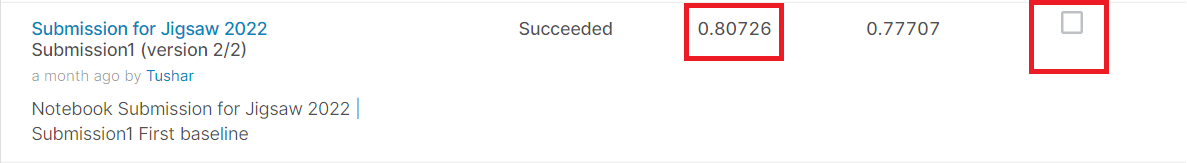

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import gc
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from kaggle_datasets import KaggleDatasets
from scipy.stats import rankdata
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tensorflow.keras.layers import Input, Dense
import transformers

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
def regular_encode(texts, tokenizer, maxlen = 512 ):
    enc_di = tokenizer.batch_encode_plus(texts,return_attention_mask = False, return_token_type_ids  = False,
                                        pad_to_max_length = True, max_length = maxlen, truncation = True)
    return np.array(enc_di["input_ids"])

In [ ]:
def build_model(transformer,maxlen = 512):
    input_word_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from kaggle_datasets import KaggleDatasets
AUTO = tf.data.experimental.AUTOTUNE

# Data access
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 5
BATCH_SIZE = 16
MAX_LEN = 152
MODEL = '../input/jplu-tf-xlm-roberta-large'

In [ ]:
test_data = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
test_data.tail()

In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        truncation=True, 
        return_token_type_ids=False,
        padding="max_length",
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
x_test = regular_encode(list(test_data.text.values), tokenizer, maxlen=MAX_LEN)

In [ ]:
transformer_layer = TFAutoModel.from_pretrained(MODEL)
model = build_model(transformer_layer, maxlen=MAX_LEN)
model.load_weights("../input/fork-of-toxic-xlm-roberta-large/xlm-large-multilingual.h5")

In [ ]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [ ]:
res = model.predict(test_dataset, verbose=1)

In [ ]:
ranked_res = rankdata(res.flatten())/1000

In [ ]:
sub = pd.DataFrame({"comment_id":test_data.comment_id, "score":ranked_res})
sub.tail()

In [ ]:
sub.to_csv("submission.csv", index=None)

In [ ]:
sub.score.value_counts(ascending=True)